In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from Minesweeper import *
from functools import reduce

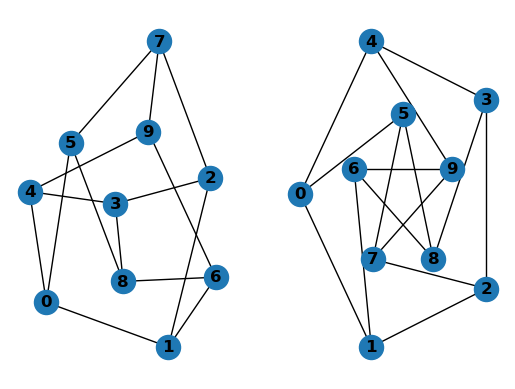

In [14]:
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [15]:
graph = nx.Graph()

graph.add_node(1, number=True)
graph.add_node(2, number=False)
graph.add_node(3, number=False)
graph.add_edge(1, 2, foo="bar")
graph.add_edge(1, 3, foo="boof")

In [16]:
for i in graph[1]:
    print(graph.nodes[i]['number'])

False
False


In [17]:
for tile_id, attr in graph.nodes.data():
    print(tile_id)
    print(attr)
    print()

1
{'number': True}

2
{'number': False}

3
{'number': False}



In [18]:
print(graph.edges.data())

[(1, 2, {'foo': 'bar'}), (1, 3, {'foo': 'boof'})]


In [8]:
for a,b,attr in graph.edges.data():
    print(a, b, attr)

1 2 {'foo': 'bar'}
1 3 {'foo': 'boof'}


In [9]:
#https://stackoverflow.com/questions/58069431/find-all-binary-strings-of-certain-weight-has-fast-as-possible

def rightmost(ls, x):
    for i in range(len(ls)):
        if ls[-(i+1)] == x:
            return len(ls) - (i+1)
    return None

def slam_right(ls, x):
    count = len([i for i in ls if i == x])
    return [i for i in ls if i != x]  + count*[x]

def swap(ls, a, b):
    ls = list(ls)
    tmp = ls[a]
    ls[a] = ls[b]
    ls[b] = tmp
    return ls


def test(n, m):
    current = (n-m)*[0] + m*[1]
    final = m*[1] + (n-m)*[0]
    yield current
    while not np.all(np.array(current) == np.array(final)):
        # Find the rightmost 0 to the left of the rightmost 1.
        rightmost0 = rightmost(current[:rightmost(current, 1)], 0)

        # move a 1 from the right into that 0
        current = swap(current, rightmost0, current[rightmost0:].index(1) + rightmost0)
        yield current

        # move all the other 1s to the right of that zero as far right as possible.
        slammed = current[:rightmost0+1] + slam_right(current[rightmost0+1:], 1)
        if not np.all(np.array(current) == np.array(slammed)):
            current = slammed
            yield current

In [10]:
current = [0, 0, 1, 0, 1, 1]
foo = current[:2+1] + slam_right(current[2+1:], 1)
print(foo)

[0, 0, 1, 0, 1, 1]


In [11]:
for i in test(5, 0):
    print(i)

[0, 0, 0, 0, 0]


In [2]:
for i in range(1, 11):
    print(str(i%10), i)

1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
0 10


In [3]:
99/(16*30)

0.20625